<a href="https://colab.research.google.com/github/sscalvo/dcgan_pokemon/blob/main/DCGAN_for_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DCGAN (Deep Convolutional Generative Adversarial Network)
#### Usin GAN to generate sinthetic POKEMONS sprites (implemented with CNN)

Based in:
- https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/mnist/01_GAN_MNIST.ipynb (MLP)
- https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py (CNN)
- https://github.com/soumith/ganhacks (TIPs and hacks to fine tune GANs)

POKEMON sprites:

 - Downloaded from https://veekun.com/dex/downloads 
 - Using 2824 sprites from zip file 'Generation IV')
 - 80 x 80 pixels
 - 8 bits / channel (max value: 256)
 - 4 channels: RGB + Alpha (We will use only RGB)

Inspired by the GPT2 Pokemon generation project, by Matthew Rayfield's:
- https://www.youtube.com/watch?v=Z9K3cwSL6uM&feature=emb_title

#### Load libraries

In [1]:
import numpy as np
import os
import shutil
import glob
import cv2
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K
import keras

### 1. Getting the data
1.1 Download and uncompress

In [3]:
!wget https://veekun.com/static/pokedex/downloads/generation-4.tar.gz
!tar -xzf generation-4.tar.gz

--2020-12-07 10:07:08--  https://veekun.com/static/pokedex/downloads/generation-4.tar.gz
Resolving veekun.com (veekun.com)... 173.255.210.122, 2600:3c01::f03c:91ff:fe93:a2d5
Connecting to veekun.com (veekun.com)|173.255.210.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13183375 (13M) [application/octet-stream]
Saving to: ‘generation-4.tar.gz’

generation-4.tar.gz 100%[===================>]  12.57M  27.8MB/s    in 0.5s    

2020-12-07 10:07:09 (27.8 MB/s) - ‘generation-4.tar.gz’ saved [13183375/13183375]



1.2 Copy images from different folders into one single folder and rename image names to sequential numeric names:
- 0.png, 1.png, 2.png, ...

In [4]:
# Collect sprites from this folders (folders not included here contain
# duplicated sprites)..
dirs_sprites = ['pokemon/main-sprites/diamond-pearl',
    'pokemon/main-sprites/diamond-pearl/frame2',
    'pokemon/main-sprites/diamond-pearl/shiny',
    'pokemon/main-sprites/diamond-pearl/shiny/frame2',
    'pokemon/main-sprites/heartgold-soulsilver',
    'pokemon/main-sprites/heartgold-soulsilver/frame2',
    'pokemon/main-sprites/heartgold-soulsilver/shiny',
    'pokemon/main-sprites/heartgold-soulsilver/shiny/frame2',
    'pokemon/main-sprites/platinum',
    'pokemon/main-sprites/platinum/frame2',
    'pokemon/main-sprites/platinum/shiny',
    'pokemon/main-sprites/platinum/shiny/frame2']


img_dir = "/content/images" # ..into this folder

!rm -rf '$img_dir' # just in case, reset..
Path(img_dir).mkdir(parents=True, exist_ok=True) # ..and restart

dirs = [ os.path.join(os.getcwd(), d) for d in dirs_sprites]
glob_paths = [ os.path.join(d, '*.png') for d in dirs] 

num_samples=0
# copy and rename with consecutive numbers: 0.png, 1.png, ...
for path in glob_paths:
    for file in glob.glob(path):
        shutil.copy(file, os.path.join(img_dir,str(num_samples) + '.png'))
        num_samples += 1
print('{} files copied from {} directories to directory \'{}\''.format(str(num_samples), str(len(dirs_sprites)), img_dir) )

6790 files copied from 12 directories to directory '/content/images'


### 2. Explore the data

img_dir: /content/images
num_samples: 6790
height: 80
width: 80
num_channels: 4


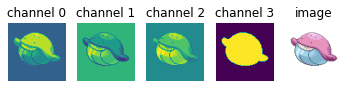

In [117]:
# Let's pick a random image:
rnd = np.random.randint(0, num_samples)
img = cv2.imread(img_dir + "/" + str(rnd) + ".png", cv2.IMREAD_UNCHANGED)
channels = img.shape[2]
for c in range(channels):
  plt.subplot(1, 5, c+1)
  plt.gca().set_title("channel " + str(c))
  plt.axis('off')
  plt.imshow(img[:,:,c])

plt.subplot(1, 5, 5)
plt.gca().set_title("image")
plt.axis('off')
_ = plt.imshow(img)

height = img.shape[0]
width  = img.shape[1]
num_channels = img.shape[2]
print("img_dir: {}".format(img_dir))
print("num_samples: {}".format(num_samples))
print("height: {}".format(height))
print("width: {}".format(width))
print("num_channels: {}".format(num_channels))

### 3. Preparing data
#### 3.1 Reducing images to 3 RGB channels (get rid of alpha channel and turn whatever was transparent into white)



In [8]:
def removeAlphaChannel(img):
  # Let's get rid of the (4th) alpha channel: Invert 1's with 0's and viceversa
  mask_blackborder = (img[:,:,3] == 255) * 1  # shape (64, 64)
  mask_blackborder = mask_blackborder[...,np.newaxis] # shape (64, 64, 1)
  # Mask color channels to make their 'border' zero
  img = img * mask_blackborder
  # Now change 0-->255 and 1-->0  (turn border white while respecting image)
  mask_whiteborder = mask_blackborder * (-255) + 255
  img = img + mask_whiteborder
  return img[:,:,0:3]
  # np.savetxt('file.txt', img[:,:,0], fmt='%3.0f', delimiter=' ')

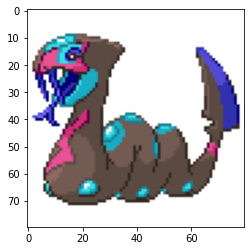

In [9]:
# Let's test removeAlphaChannel
imgRGB = removeAlphaChannel(img)
_ = plt.imshow(imgRGB)

#### 3.2 Load images into numpy array and shuffle

In [53]:
X = np.zeros((num_samples, height, width, channels-1), dtype=np.int)
print(X.shape)
i = 0
for file in glob.glob(os.path.join(img_dir) + "/*"):
  img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
  X[i,:,:,:] = reduceChannels(img)
  i += 1

! shuffle aqui

(6790, 80, 80, 3)


#### Explore visual data

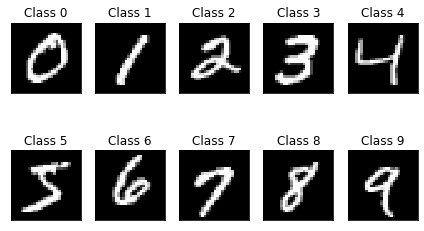

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing

In [ ]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


#### Generator

In [ ]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)
# what kind of values does init generate?:
# values = init(shape=(2, 2))  --->  [[-0.02225484,  0.00808221], [-0.01560519,  0.01039954]]

# Generator network
generator = Sequential()

# FC: 7x7x256
generator.add(Dense(7*7*128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((7, 7, 128)))

# Conv 1: 14x14x128
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2: 28x28x64
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# # Conv 3: 28x28x32
# generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(ReLU(0.2))

# Conv 4: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))

#### Generator model visualization

In [ ]:
# prints a summary representation of your model
generator.summary()

### Discriminator
TIP 5: Avoid Sparse Gradients (ReLU, MaxPool) <br/>
TODO: TIP 9: Use the ADAM Optimizer for discriminator

In [ ]:
# Discriminator network
discriminator = Sequential()

# Conv 1: 14x14x64
discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                         input_shape=(28, 28, 1), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [ ]:
# prints a summary representation of your model
discriminator.summary()

### 3. Compile model

In [ ]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

### GAN: Stack generator & discriminator

In [ ]:
z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
# prints a summary representation of your model
d_g.summary()

### Fit model
TIP 3: Use a spherical Z <br/>
TIP 4: BatchNorm <br/>
TIP 6: Use Soft and Noisy Labels

In [ ]:
epochs = 100
batch_size = 64
smooth = 0.1

# real = np.ones(shape=(batch_size, 1))
real_smoothed = np.random.uniform(low=0.7, high=1.2, size=(batch_size,))
# fake = np.zeros(shape=(batch_size, 1))
fake_smoothed = np.random.uniform(low=0.0, high=0.3, size=(batch_size,))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        # d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real_smoothed)
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        # d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake_smoothed)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        # discriminator.save('/content/drive/MyDrive/AI/GAN/dcgan_mafda/discriminator',  overwrite=True)
        # generator.save('/content/drive/MyDrive/AI/GAN/dcgan_mafda/generator',  overwrite=True)
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

In [ ]:
# discriminator.save('/content/drive/MyDrive/AI/GAN/dcgan_mafda/discriminator',  overwrite=True)
# generator.save('/content/drive/MyDrive/AI/GAN/dcgan_mafda/generator',  overwrite=True)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI/GAN/dcgan_mafda/discriminator/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI/GAN/dcgan_mafda/generator/assets


In [ ]:
batch_size = 64
latent_dim=100
discriminator = keras.models.load_model('/content/drive/MyDrive/AI/GAN/dcgan_mafda/discriminator')
generator  = keras.models.load_model('/content/drive/MyDrive/AI/GAN/dcgan_mafda/generator')

In [ ]:
z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
X_fake = generator.predict_on_batch(z)
discriminator.trainable = False
y_hat = discriminator.predict(X_fake)

### Explore results

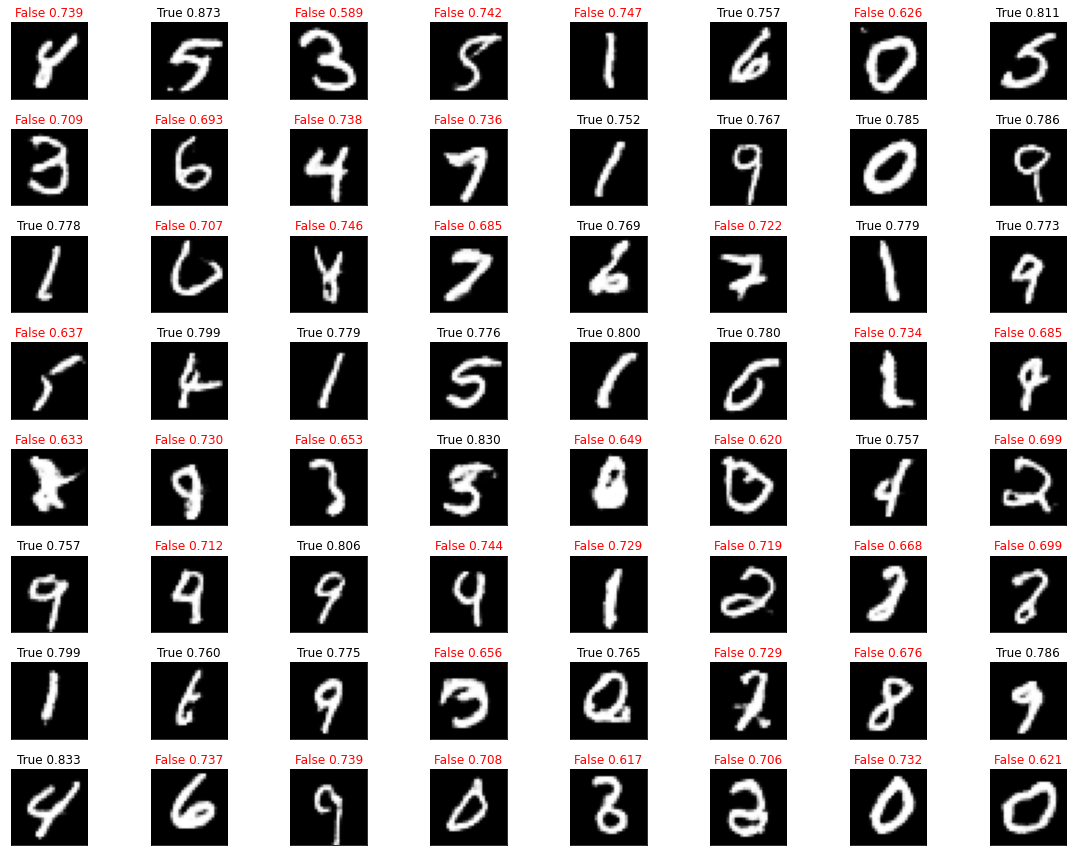

In [ ]:
fig=plt.figure(figsize=(16, 12))
for k in range(batch_size):
    fig.add_subplot(8, 8, k+1)
    title = plt.gca().set_title(str((y_hat[k] > 0.75)[0]) + ' {:.3f}'.format(y_hat[k][0]))
    if (y_hat[k] < 0.75)[0]: plt.setp(title, color='r')
    plt.imshow(X_fake[k].reshape(28, 28), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()